In [1]:
from lsst.daf.butler import Butler
from lsst.afw.table import ExposureCatalog, SchemaMapper
from importlib import reload
import numpy as np


In [2]:
import logging
reload(logging)
from lsst.utils.logging import VERBOSE

logging.basicConfig(level=VERBOSE)

In [3]:
butler = Butler("dp2_prep", collections="LSSTCam/runs/DRP/20250421_20250921/d_2025_11_10/DM-53195", skymap="lsst_cells_v2")

INFO:sqlalchemy.engine.Engine:select pg_catalog.version()
INFO:sqlalchemy.engine.Engine:[raw sql] {}
INFO:sqlalchemy.engine.Engine:select current_schema()
INFO:sqlalchemy.engine.Engine:[raw sql] {}
INFO:sqlalchemy.engine.Engine:show standard_conforming_strings
INFO:sqlalchemy.engine.Engine:[raw sql] {}
INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM pg_extension WHERE extname='btree_gist';
INFO:sqlalchemy.engine.Engine:[generated in 0.00061s] {}
INFO:sqlalchemy.engine.Engine:SHOW server_version
INFO:sqlalchemy.engine.Engine:[generated in 0.00031s] {}
INFO:sqlalchemy.engine.Engine:ROLLBACK
INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s]) AND pg_catalog.pg_class.relpersistence != %(re

In [131]:
# visit = 2025091900191
visit = 2025052300137

In [132]:
input_schema = butler.get("visit_summary_schema").schema

INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:WITH RECURSIVE chains(collection_id, name, type, doc, parent, position) AS 
(SELECT coll_1.collection_id AS collection_id, coll_1.name AS name, coll_1.type AS type, coll_1.doc AS doc, CAST(NULL AS BIGINT) AS parent, CAST(NULL AS SMALLINT) AS position 
FROM dp2_prep.collection AS coll_1 
WHERE coll_1.name IN (%(name_1_1)s) UNION ALL SELECT coll_2.collection_id AS collection_id, coll_2.name AS name, coll_2.type AS type, coll_2.doc AS doc, chain_2.parent AS parent, chain_2.position AS position 
FROM dp2_prep.collection AS coll_2 JOIN dp2_prep.collection_chain AS chain_2 ON coll_2.collection_id = chain_2.child JOIN chains AS anon_1 ON chain_2.parent = anon_1.collection_id)
 SELECT chains.collection_id, chains.name, chains.type, chains.doc, chains.parent, chains.position, dp2_prep.run.host, dp2_prep.run.timespan 
FROM chains LEFT OUTER JOIN dp2_prep.run ON chains.collection_id = dp2_prep.run.collection_id
INFO:sqla

In [133]:
input_summary = butler.get("visit_summary", visit=visit)

INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:WITH RECURSIVE chains(collection_id, name, type, doc, parent, position) AS 
(SELECT coll_1.collection_id AS collection_id, coll_1.name AS name, coll_1.type AS type, coll_1.doc AS doc, CAST(NULL AS BIGINT) AS parent, CAST(NULL AS SMALLINT) AS position 
FROM dp2_prep.collection AS coll_1 
WHERE coll_1.name IN (%(name_1_1)s) UNION ALL SELECT coll_2.collection_id AS collection_id, coll_2.name AS name, coll_2.type AS type, coll_2.doc AS doc, chain_2.parent AS parent, chain_2.position AS position 
FROM dp2_prep.collection AS coll_2 JOIN dp2_prep.collection_chain AS chain_2 ON coll_2.collection_id = chain_2.child JOIN chains AS anon_1 ON chain_2.parent = anon_1.collection_id)
 SELECT chains.collection_id, chains.name, chains.type, chains.doc, chains.parent, chains.position, dp2_prep.run.host, dp2_prep.run.timespan 
FROM chains LEFT OUTER JOIN dp2_prep.run ON chains.collection_id = dp2_prep.run.collection_id
INFO:sqla

In [134]:
camera = butler.get("camera", visit=visit)

INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:SELECT dp2_prep.visit.instrument, dp2_prep.visit.id, dp2_prep.visit.day_obs, dp2_prep.visit.physical_filter, dp2_prep.visit.name, dp2_prep.visit.seq_num, dp2_prep.visit.exposure_time, dp2_prep.visit.target_name, dp2_prep.visit.observation_reason, dp2_prep.visit.science_program, dp2_prep.visit.azimuth, dp2_prep.visit.zenith_angle, dp2_prep.visit.region, dp2_prep.visit.timespan 
FROM dp2_prep.visit 
WHERE dp2_prep.visit.instrument = %(instrument_1)s AND dp2_prep.visit.id = %(id_1)s
INFO:sqlalchemy.engine.Engine:[cached since 3.816e+04s ago] {'instrument_1': 'LSSTCam', 'id_1': 2025052300137}
INFO:sqlalchemy.engine.Engine:ROLLBACK
INFO:sqlalchemy.engine.Engine:BEGIN (implicit)
INFO:sqlalchemy.engine.Engine:SELECT dp2_prep.day_obs.instrument, dp2_prep.day_obs.id, dp2_prep.day_obs.timespan 
FROM dp2_prep.day_obs 
WHERE dp2_prep.day_obs.instrument = %(instrument_1)s AND dp2_prep.day_obs.id = %(id_1)s
INFO:sqlalchemy.

In [135]:
import lsst.meas.astrom.refit_pointing
reload(lsst.meas.astrom.refit_pointing)
RefitPointingTask = lsst.meas.astrom.refit_pointing.RefitPointingTask

In [136]:
mapper = SchemaMapper(input_schema)
mapper.addMinimalSchema(input_schema, True)
schema = mapper.getOutputSchema()
config = RefitPointingTask.ConfigClass()
task = RefitPointingTask(config=config, schema=schema)

In [137]:
catalog = ExposureCatalog(schema)
catalog.extend(input_summary, mapper=mapper)

In [138]:
result = task.run(catalog=catalog, camera=camera)

INFO:lsst.refitPointing:Re-fit pointing is (150.1963946201, +2.0228143240), orientation=85.33 deg (0.008 deg from the original boresight).
Level 15:lsst.refitPointing:SIP approximation for detector 1 has pixelToSky good to ≤ 0.00072 mas and skyToPixel good to ≤ 0.012 mas.
Level 15:lsst.refitPointing:SIP approximation for detector 2 has pixelToSky good to ≤ 0.00019 mas and skyToPixel good to ≤ 0.0023 mas.
Level 15:lsst.refitPointing:SIP approximation for detector 3 has pixelToSky good to ≤ 0.00021 mas and skyToPixel good to ≤ 0.0015 mas.
Level 15:lsst.refitPointing:SIP approximation for detector 4 has pixelToSky good to ≤ 0.00052 mas and skyToPixel good to ≤ 0.01 mas.
Level 15:lsst.refitPointing:SIP approximation for detector 5 has pixelToSky good to ≤ 0.00015 mas and skyToPixel good to ≤ 0.004 mas.
Level 15:lsst.refitPointing:SIP approximation for detector 6 has pixelToSky good to ≤ 0.00032 mas and skyToPixel good to ≤ 0.0037 mas.
Level 15:lsst.refitPointing:SIP approximation for detec

In [ ]:
from __future__ import annotations

from typing import TYPE_CHECKING, Any

from lsst.afw.geom import makeSkyWcs, SkyWcs
from lsst.afw.cameraGeom import Detector, FIELD_ANGLE, PIXELS
from lsst.geom import Angle, Point2D, SpherePoint, degrees
from lsst.obs.base.utils import createInitialSkyWcsFromBoresight
from lsst.sphgeom import ConvexPolygon
import matplotlib as mpl

if TYPE_CHECKING:
    from matplotlib.axes import Axes
    from matplotlib.figure import Figure

def plot(
    result,
    axes: Axes | None = None,
    figure: Figure | None = None,
    proj: SkyWcs | None = None,
    figure_kwargs: dict[str, Any] | None = None,
    fit_region_style: dict[str, Any] | None = None,
    raw_region_style: dict[str, Any] | None = None,
    fallback_region_style: dict[str, Any] | None = None,
    raw_axes_style: dict[str, Any] | None = None,
    fallback_axes_style: dict[str, Any] | None = None,
    plot_all_fallback: bool = False,
) -> tuple[Axes, SkyWcs]:
    if axes is None:
        if proj is None:
            proj = makeSkyWcs(Point2D(0.0, 0.0), result.boresight, np.identity(2))
        if figure is None:
            from lsst.utils.plotting import make_figure

            figure = make_figure(**(figure_kwargs or {}))
        axes = figure.add_subplot()
        axes.set_title(f"visit={visit}")
        axes.set_xlabel("local right ascension (deg)")
        axes.set_ylabel("local declination (deg)")
    elif proj is None:
        raise TypeError("proj must be provided if axes is provided.")
    if fallback_region_style is not None:
        fallback_region_style["label"] = "refit pointing + camera geom"
        fallback_wcs: SkyWcs | None = None
        detector: Detector
        for detector in camera:
            record = result.catalog.find(detector.getId())
            has_fit_wcs = record is not None and record.getWcs() is not None
            if plot_all_fallback or not has_fit_wcs:
                fallback_wcs = result.fallbacks[detector.getId()]
                corners = fallback_wcs.pixelToSky(detector.getCorners(PIXELS))
                _plot_polygon(
                    axes, proj, ConvexPolygon([sp.getVector() for sp in corners]),
                    **fallback_region_style,
                )
                fallback_region_style.pop("label", None)
        if fallback_axes_style is not None:
            _plot_field_angle_axes(
                axes,
                proj,
                Angle(1.0, degrees),
                fallback_wcs,
                detector,
                **fallback_axes_style,
                label="refit pointing"
            )
    raw_wcs = None
    if fit_region_style is not None:
        norm = mpl.colors.LogNorm(vmin=0.1, vmax=60)
        cmap = mpl.colormaps["cividis"]
        fit_region_style["label"] = "GBDES"
        for record in result.catalog:
            fit_wcs = record.getWcs()
            if fit_wcs is not None:
                detector = camera[record.getId()]
                corners = fit_wcs.pixelToSky(detector.getCorners(PIXELS))
                if record["wcs_detector_pointing_rejected"]:
                    hatch = "XX"
                else:
                    hatch = None
                _plot_polygon(axes, proj, ConvexPolygon([sp.getVector() for sp in corners]),
                              facecolor=cmap(norm(record["wcs_detector_pointing_residual"].asArcseconds())),
                              **fit_region_style, hatch=hatch)
                fit_region_style.pop("label", None)
        if figure is not None:
            cbar = figure.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes,
                alpha=fit_region_style.get("alpha", 1.0),
            )
            cbar.set_label("wcs_detector_pointing_residual (arcsec)")
    if raw_region_style is not None:
        raw_region_style["label"] = "raw pointing + camera geom"
        visit_info = catalog[0].getVisitInfo()
        for detector in camera:
            raw_wcs = createInitialSkyWcsFromBoresight(
                visit_info.getBoresightRaDec(),
                visit_info.getBoresightRotAngle(),
                detector=detector,
            )
            detector = camera[detector.getId()]
            corners = raw_wcs.pixelToSky(detector.getCorners(PIXELS))
            _plot_polygon(axes, proj, ConvexPolygon([sp.getVector() for sp in corners]), **raw_region_style)
            raw_region_style.pop("label", None)
        if raw_axes_style is not None:
            _plot_field_angle_axes(axes, proj, Angle(1.0, degrees), raw_wcs, detector, **raw_axes_style,
                                label="raw pointing")
    axes.axis("equal")
    return axes, proj

@staticmethod
def _plot_polygon(
    axes: Axes,
    proj: SkyWcs,
    polygon: ConvexPolygon,
    **style: Any,
) -> None:
    vertices = np.array(proj.skyToPixel([SpherePoint(v) for v in polygon.getVertices()]))
    axes.fill(vertices[:, 0], vertices[:, 1], **style)

def _plot_field_angle_axes(
    axes: Axes,
    proj: SkyWcs,
    size: Angle,
    detector_wcs: SkyWcs,
    detector: Detector,
    **style: Any,
) -> None:
    origin_sky = detector_wcs.pixelToSky(
        detector.transform(Point2D(0.0, 0.0), FIELD_ANGLE, PIXELS)
    )
    y_axis_sky = detector_wcs.pixelToSky(
        detector.transform(Point2D(0.0, size.asRadians()), FIELD_ANGLE, PIXELS)
    )
    x_axis_sky = detector_wcs.pixelToSky(
        detector.transform(Point2D(size.asRadians(), 0.0), FIELD_ANGLE, PIXELS)
    )
    points = np.array(proj.skyToPixel([x_axis_sky, origin_sky, y_axis_sky]))
    axes.plot(points[:, 0], points[:, 1], **style)
    axes.text(points[0, 0], points[0, 1], "+X")
    axes.text(points[2, 0], points[2, 1], "+Y")



TypeError: Colorbar.__init__() got an unexpected keyword argument 'title'

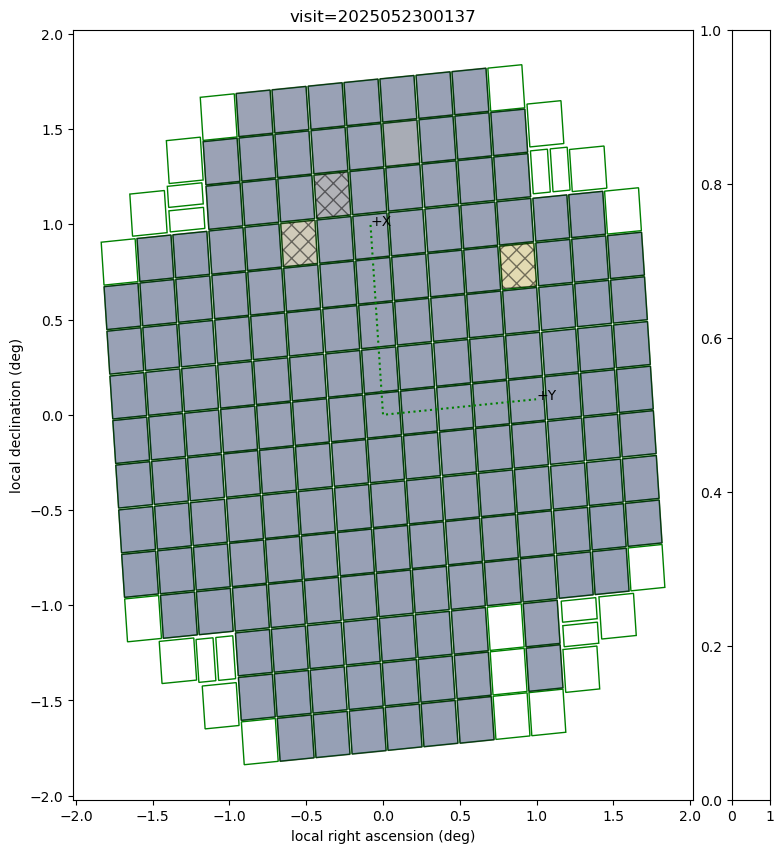

In [146]:
from matplotlib import pyplot

figure = pyplot.figure(figsize=(10, 10))

axes, proj = plot(
    result,
    figure=figure,
    fit_region_style=dict(fill=True, edgecolor="k", alpha=0.5),
    raw_region_style=dict(fill=False, edgecolor="r"),
    fallback_region_style=dict(fill=False, edgecolor="g"),
    raw_axes_style=dict(color="r", linestyle=":"),
    fallback_axes_style=dict(color="g", linestyle=":"),
    plot_all_fallback=True,
)
axes.legend()

In [106]:
cm = mpl.colormaps["cividis"]

In [107]:
norm = mpl.colors.LogNorm(vmin=1E-3, vmax=3600)

np.float64(0.6100999762490943)